In [1]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'svg'

## Import module

In [2]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import torch
import os
import numpy as np
from torchsummary import summary
from torchvision import transforms                                                                                                                                        
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 600
from PIL import Image
import pandas as pd

import sys
sys.path.append("../../src/")
sys.path.append("../")
import model
from datasets import imagenet
import config
from aux.utils import obtain_features_map, load_imgs, zscore, extract_valid
from aux.visualization import visualize_features_map
from aux.visualization import visualize_features_map_for_comparision
from utils.visualizations.visualize import concat_imgs, preprocess_arrays

## Main

In [12]:
def main(exp, selected_layer, selected_filter, class_index=950):
    num_class = 30
    class_index = class_index
    print("=> class index: {}".format(class_index))
    backbone = "vgg16"
    resume = "037-0"
    color_map = "jet"
    model_dir = "/home/lincolnzjx/Desktop/Interpretation/saved/models"
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    
    ## Load modal from dict
    
    # model
    net = model.Network(backbone=backbone, num_classes=1000, 
                        selected_layer=selected_layer)
    net.to(device)
    
    # resume from model
    resume_exp = resume.split("-")[0]
    resume_epoch = resume.split("-")[1]
    print("Resume from model from exp: {} at epoch {}".format(resume_exp, resume_epoch))
    resume_path = os.path.join(model_dir, str(resume_exp), str(resume_epoch))
    ckpt = torch.load(resume_path, map_location=device)
    net.load_state_dict(ckpt, strict=False) 
    
    summary(net, (3, 224, 224))
    
    ## Load Original Data 
    
    # Load data
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    reverse_mean = [-0.485, -0.456, -0.406]
    reverse_std = [1/0.229, 1/0.224, 1/0.225]
    train_transform = None
    train_transform = transforms.Compose([                                                                                                                                
        transforms.Resize((224, 224), interpolation=Image.BILINEAR),                                                                                              
        transforms.ToTensor(),                                                                                                                                            
        #transforms.Normalize(mean, std)                                                                                                                                   
           ])         
    trainset = imagenet.ImageNet(root="/media/lincolnzjx/HardDisk/Datasets/", 
                                 is_train=True, transform=train_transform)
    
    trainset.set_data([class_index], num_class)
    imgs_path = []                                                                                                                                                            
    images = []
    labels = []
    for img, label, img_path in trainset:                                                                                                                                     
        images.append(img.unsqueeze(0))                                                                                                                                       
        labels.append(label)                                                                                                                                                  
        imgs_path.append(img_path)  
    
    ## Create some need path
    
    save_dir = "./generated/"
    ################### Hyper-Parameter #######################
    # exp = resume_exp
    # epoch = resume_epoch
    ##########################################################
    ab_path = os.path.join(save_dir, exp)
    
    index2image = {index: item.split("/")[-1].split(".")[0] for index, item in enumerate(imgs_path)}
    index2image
    
    images_cpu = np.array([image.detach().clone().cpu().numpy().squeeze() for image in images])
    
    # Load image
    # ext may be different.
    optimized_data, valid_imgs_path, valid_imgs_index = load_imgs(ab_path, imgs_path, non_exists_ok=True, ext=".png")
    valid_imgs, valid_labels = extract_valid(images, labels, valid_imgs_index)
    optimized_data_zscore = zscore(optimized_data, mean, std)
    images_zscore = zscore(images_cpu, mean, std)
    
    # Move to device
    opt_image = torch.from_numpy(optimized_data_zscore).to(device)
    original_image = torch.from_numpy(images_zscore).to(device)
    
    ## Obtain feature from conv layers.
    
    ori_activation_maps = net.get_activation_maps(original_image, 
                                                  selected_layer=selected_layer)[0]
    opt_activation_maps = net.get_activation_maps(opt_image, 
                                                  selected_layer=selected_layer)[0]
    
    images_cpu, optimized_data_cpu, ori_activation_maps_cpu, \
       opt_activation_maps_cpu, optimized_data_cpu_scale, \
       diff_activation_maps_cpu,\
       ori_activation_maps_cpu_n1e1, opt_activation_maps_cpu_n1e1, \
       diff_activation_maps_cpu_n1e1,\
       ori_activation_maps_cpu_n2e1, opt_activation_maps_cpu_n2e1, \
       diff_activation_maps_cpu_n2e1,\
       ori_activation_maps_cpu_n4e1, opt_activation_maps_cpu_n4e1,\
       diff_activation_maps_cpu_n4e1 = \
       preprocess_arrays(images_cpu, optimized_data,
                         ori_activation_maps, opt_activation_maps,
                         selected_filter, color_map=color_map)
    concated_imgs, concated_fms, concated_imgs_fms, out_not_resize_img = \
      concat_imgs(
        images_cpu, optimized_data_cpu,
        ori_activation_maps_cpu, opt_activation_maps_cpu,
        optimized_data_cpu_scale, diff_activation_maps_cpu,
        ori_activation_maps_cpu_n1e1, opt_activation_maps_cpu_n1e1,
        diff_activation_maps_cpu_n1e1,
        ori_activation_maps_cpu_n2e1, opt_activation_maps_cpu_n2e1,
        diff_activation_maps_cpu_n2e1,
        ori_activation_maps_cpu_n4e1, opt_activation_maps_cpu_n4e1,
        diff_activation_maps_cpu_n4e1)
    # imgs
    save_imgs_path = os.path.join("./generated", exp, "concat.png")
    concated_imgs.save(save_imgs_path)
    # fms 
    save_fms_path = os.path.join("./generated", exp, 
                                  "concat_fms.png")
    concated_fms.save(save_fms_path)
    # imgs & fms
    save_imgs_fms_path = os.path.join("./generated", exp, 
                                      "concat_imgs_fms.png")
    concated_imgs_fms.save(save_imgs_fms_path)
    # not_resize
    save_imgs_not_resize_path = os.path.join("./generated", exp,
                                             "concat_imgs_fm_not_resize.png")
    out_not_resize_img.save(save_imgs_not_resize_path)
    
    
    save_dict = {
        "save_dir": "./generated/"+ exp + "/feature_map/",
        "index2image": index2image, 
        "save_name": "layer-{}-{}.pdf"
    }
    try: 
        os.mkdir(save_dict["save_dir"])
    except FileExistsError:
        print("Directory has been created {}".format(save_dict["save_dir"]))
        
    conv_output_indexes_dict = {0:0}
    layer_index = 0
    print(ori_activation_maps.shape)
    visualize_features_map_for_comparision(img_index=12, layer_index=layer_index, 
                                           features_map=[ori_activation_maps], 
                                           opt_feature_map=[opt_activation_maps], 
                                           cols=8, 
                                           conv_output_index_dict=conv_output_indexes_dict, 
                                           save_dict=save_dict, is_save=True,
                                           #plt_mode="img_scale", 
                                           plt_mode="single", 
                                           color_map = color_map,
                                           layer_name=selected_layer,
                                           selected_filter=selected_filter)

## PATH

## RUN

### Class14

In [13]:
# excel_path = "Single.xlsx"
excel_path = "../analysis/week9/Batches.xlsx"
sheet = "Others"
# sheet = "950"
excepts = ["052148"]

=> Skip
=> RUN  052198 3 20 14
=> class index: 14
Only Keep 3th layers before.
Resume from model from exp: 037 at epoch 0
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
             VGG16-5         [-1, 64, 224, 224]               0
Total params: 38,720
Trainable params: 38,720
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.57
Forward/backward pass size (MB): 122.50
Params size (MB): 0.15
Estimated Total Size (MB): 123.22
----------------------------------------------------------------
Len of new dataset is :30
['100000', '20000', 'feature_map']
[]
[]
[]
(30, 224, 224, 3)
(30, 3, 224, 224)
=> R

../aux/visualization.py:119: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



Successfully Save pdf to ./generated/052198/feature_map/layer-3-n01537544_10110.pdf


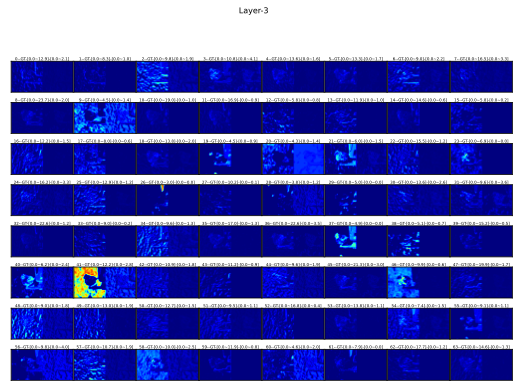

In [15]:
xlsx = pd.ExcelFile(excel_path)
excel = pd.read_excel(xlsx, sheet, Sdtype={"exp": str, 
                                           "selected_layer": int,
                                           "selected_filter": int, 
                                           "class_index": int,
                                            "Done": str}).values
for data in excel:
    exp, selected_layer, selected_filter, class_index, done = data[0], data[1], \
        data[2], data[3], data[4]
    exp = exp.replace("x", "")
    if exp in excepts:
        print("=> Skip")
    else:
        if done == "N":
            print("=> RUN ", exp, selected_layer, selected_filter, class_index)
            main(exp, selected_layer, selected_filter, class_index)

### Class 950

In [16]:
# excel_path = "Single.xlsx"
excel_path = "../analysis/week9/Batches.xlsx"
sheet = "Others"
# sheet = "950"
excepts = ["052148"]

=> Skip
=> RUN  052198 3 20 14
=> class index: 14
Only Keep 3th layers before.
Resume from model from exp: 037 at epoch 0
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
             VGG16-5         [-1, 64, 224, 224]               0
Total params: 38,720
Trainable params: 38,720
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.57
Forward/backward pass size (MB): 122.50
Params size (MB): 0.15
Estimated Total Size (MB): 123.22
----------------------------------------------------------------
Len of new dataset is :30
['100000', '20000', 'feature_map']
[]
[]
[]
(30, 224, 224, 3)
(30, 3, 224, 224)
=> R

../aux/visualization.py:119: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



Successfully Save pdf to ./generated/052198/feature_map/layer-3-n01537544_10110.pdf


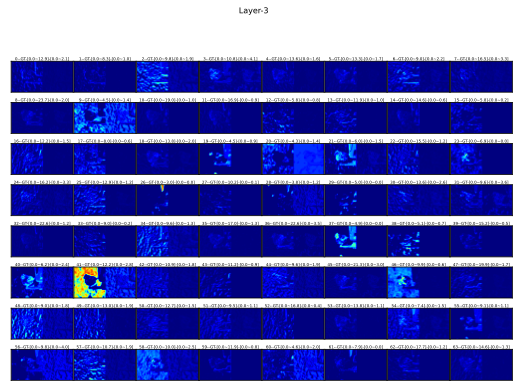

In [17]:
xlsx = pd.ExcelFile(excel_path)
excel = pd.read_excel(xlsx, sheet, Sdtype={"exp": str, 
                                           "selected_layer": int,
                                           "selected_filter": int, 
                                           "class_index": int,
                                            "Done": str}).values
for data in excel:
    exp, selected_layer, selected_filter, class_index, done = data[0], data[1], \
        data[2], data[3], data[4]
    exp = exp.replace("x", "")
    if exp in excepts:
        print("=> Skip")
    else:
        if done == "N":
            print("=> RUN ", exp, selected_layer, selected_filter, class_index)
            main(exp, selected_layer, selected_filter, class_index)